In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Here in this experiment we are going to look into how the complexity of a neural net affects the effectiveness of adversarial training and robustness of the model. </br>
We will use the CIFAR10 dataset and convolutional neural networks to do our experiments.</br>
This experiment will use PGD to compare how two neural networks of different complexities change the result of adversarial training

In [20]:
# Loading the CIFAR10 dataset in
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizing the pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

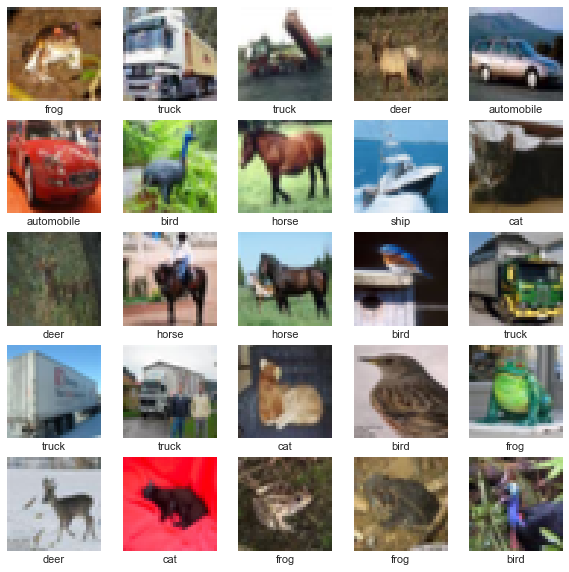

In [21]:
# Plot the CIFAR10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [22]:
# Create the more simple convolution neural net, i.e. less layers and nodes
narrow_model = models.Sequential()
narrow_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
narrow_model.add(layers.MaxPooling2D((2, 2)))
narrow_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
narrow_model.add(layers.MaxPooling2D((2, 2)))
narrow_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
narrow_model.add(layers.Flatten())
narrow_model.add(layers.Dense(32, activation='relu'))
narrow_model.add(layers.Dense(10))
narrow_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [23]:
# Create more complex convolutional neural net
wide_model = models.Sequential()
wide_model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
wide_model.add(layers.MaxPooling2D((2, 2)))
wide_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
wide_model.add(layers.MaxPooling2D((2, 2)))
wide_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
wide_model.add(layers.Flatten())
wide_model.add(layers.Dense(256, activation='relu'))
wide_model.add(layers.Dense(10))
wide_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)         590080    
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [24]:
# Train narrow_model without adversarial inputs
print("Training narrow_model \n===========================================================")
narrow_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

narrow_history = narrow_model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

# Train wide_model without adversarial inputs
print("Training wide_model \n===========================================================")
wide_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

wide_history = wide_model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Training narrow_model 
Epoch 1/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5840 - accuracy: 0.4122 - val_loss: 1.2950 - val_accuracy: 0.5399
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1899 - accuracy: 0.5791 - val_loss: 1.1410 - val_accuracy: 0.5992
Epoch 3/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.0354 - accuracy: 0.6354 - val_loss: 1.0606 - val_accuracy: 0.6327
Epoch 4/10
1563/1563 [==============================] - 23s 14ms/step - loss: 0.9404 - accuracy: 0.6719 - val_loss: 0.9181 - val_accuracy: 0.6806
Epoch 5/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8704 - accuracy: 0.6969 - val_loss: 0.9323 - val_accuracy: 0.6768
Epoch 6/10
1563/1563 [==============================] - 23s 14ms/step - loss: 0.8146 - accuracy: 0.7165 - val_loss: 0.8799 - val_accuracy: 0.7035
Epoch 7/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7643 - accuracy: 0.73

313/313 - 1s - loss: 0.8991 - accuracy: 0.7053


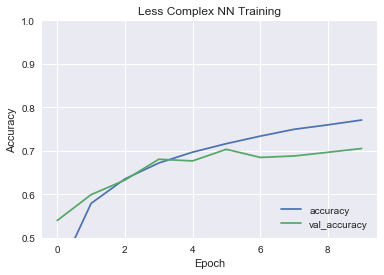

In [106]:
plt.plot(narrow_history.history['accuracy'], label='accuracy')
plt.plot(narrow_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Less Complex NN Training')
plt.savefig('NonAdvNarrowTraining.png')

test_loss, test_acc = narrow_model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 5s - loss: 1.2607 - accuracy: 0.7161


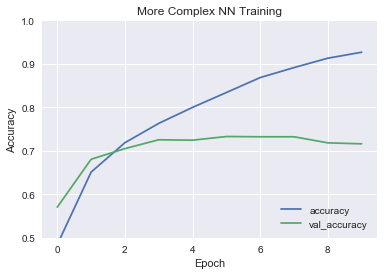

In [107]:
plt.plot(wide_history.history['accuracy'], label='accuracy')
plt.plot(wide_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('More Complex NN Training')
plt.savefig('NonAdvWideTraining.png')

test_loss, test_acc = wide_model.evaluate(test_images,  test_labels, verbose=2)

In [72]:
# Here define functions to generate adversarial atacks to train on
def single_multistep_adversarial_attack(input_image, input_label, input_channels, model, eps, a, T):
    loss_object = keras.losses.CategoricalCrossentropy(from_logits=True)
    img_rows = input_image.shape[0]
    img_cols = input_image.shape[1]
    channels = input_channels
    image_temp = tf.cast(input_image.reshape((1, img_rows, img_cols, channels)), tf.float32)      
      
    for t in range(T):
        #Define the step size
        step_size = (1 - a*t)**(-1)
      
        with tf.GradientTape() as tape:
            tape.watch(image_temp)

            #Predict the label of the image
            prediction = tf.transpose(model(image_temp))
            input_label = input_label.reshape((input_label.shape[0],1))
            #Calculate the loss between the true label and the prediction
            loss = loss_object(input_label, prediction)

        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, image_temp)

        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)

        image_temp = image_temp + signed_grad * step_size


    return tf.reshape(image_temp, [img_rows, img_cols, input_channels])


def multistep_adversarial_attack(images, labels, channels, model, eps, a, T):
    adv_images = []
    for i, (x, y) in enumerate(zip(images, labels)):
        adv_images.append(single_multistep_adversarial_attack(x, y, channels, model, eps, a, T).numpy())
        if (i % 500 == 0):
            print('{} Images done'.format(i))

    return np.asarray(adv_images)

In [74]:
# Now generate adversarial attack from our dataset and add them them to the training set and test sets (This code will take a couple of hours to run)
train_lables_categorical = tf.keras.utils.to_categorical(train_labels, len(class_names))
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, len(class_names))

num_of_adversarial_train = 8000
num_of_adversarial_test = 2000

narrow_adversarial_train_images = multistep_adversarial_attack(
    train_images[0:num_of_adversarial_train], 
    train_lables_categorical[0:num_of_adversarial_train],
    3, narrow_model, 0.1, 0.001, 100)
print('Narrow Train Done')

narrow_adversarial_test_images = multistep_adversarial_attack(
    test_images[0:num_of_adversarial_test], 
    test_labels_categorical[0:num_of_adversarial_test], 
    3, narrow_model, 0.1, 0.001, 100)
print('Narrow Test Done')

wide_adversarial_train_images = multistep_adversarial_attack(
    train_images[0:num_of_adversarial_train], 
    train_lables_categorical[0:num_of_adversarial_train], 
    3, wide_model, 0.1, 0.001, 100)
print('Wide Train Done')

wide_adversarial_test_images = multistep_adversarial_attack(
    test_images[0:num_of_adversarial_test], 
    test_labels_categorical[0:num_of_adversarial_test], 
    3, wide_model, 0.1, 0.001, 100)
print('Wide Test Done')

0 Images done
500 Images done
1000 Images done
1500 Images done
2000 Images done
2500 Images done
3000 Images done
3500 Images done
4000 Images done
4500 Images done
5000 Images done
5500 Images done
6000 Images done
6500 Images done
7000 Images done
7500 Images done
Narrow Train Done
0 Images done
500 Images done
1000 Images done
1500 Images done
Narrow Test Done
0 Images done
500 Images done
1000 Images done
1500 Images done
2000 Images done
2500 Images done
3000 Images done
3500 Images done
4000 Images done
4500 Images done
5000 Images done
5500 Images done
6000 Images done
6500 Images done
7000 Images done
7500 Images done
Wide Train Done
0 Images done
500 Images done
1000 Images done
1500 Images done
Wide Test Done


In [96]:
# Add the adversarial examples to the dataset
narrow_train_images = np.append(train_images, narrow_adversarial_train_images, axis=0)
narrow_train_labels = np.append(train_labels, train_labels[0:num_of_adversarial_train], axis=0)
narrow_test_images = np.append(test_images, narrow_adversarial_test_images, axis=0)
narrow_test_labels = np.append(test_labels, test_labels[0:num_of_adversarial_test], axis=0)

wide_train_images = np.append(train_images, wide_adversarial_train_images, axis=0)
wide_train_labels = np.append(train_labels, train_labels[0:num_of_adversarial_train], axis=0)
wide_test_images = np.append(test_images, wide_adversarial_test_images, axis=0)
wide_test_labels = np.append(test_labels, test_labels[0:num_of_adversarial_test], axis=0)

In [97]:
# Test the non adversarial models on the adversarial test data
narrow_nonadv_test_loss, narrow_nonadv_test_acc = narrow_model.evaluate(narrow_test_images,  narrow_test_labels, verbose=2)
wide_nonadv_test_loss, wide_nonadv_test_acc = wide_model.evaluate(wide_test_images,  wide_test_labels, verbose=2)

print('Non adversarial trained narrow model accuracy on adversarial test set: {:.4f}'.format(narrow_nonadv_test_acc))
print('Non adversarial trained wide model accuracy on adversarial test set: {:.4f}'.format(wide_nonadv_test_acc))

375/375 - 2s - loss: 2107.8457 - accuracy: 0.5878
375/375 - 6s - loss: 3127.9009 - accuracy: 0.5968
Non adversarial trained narrow model accuracy on adversarial test set: 0.5878
Non adversarial trained wide model accuracy on adversarial test set: 0.5968


In [98]:
# Recreate and compile the same models
adv_narrow_model = models.Sequential()
adv_narrow_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
adv_narrow_model.add(layers.MaxPooling2D((2, 2)))
adv_narrow_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
adv_narrow_model.add(layers.MaxPooling2D((2, 2)))
adv_narrow_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
adv_narrow_model.add(layers.Flatten())
adv_narrow_model.add(layers.Dense(32, activation='relu'))
adv_narrow_model.add(layers.Dense(10))
adv_narrow_model.summary()

adv_wide_model = models.Sequential()
adv_wide_model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
adv_wide_model.add(layers.MaxPooling2D((2, 2)))
adv_wide_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
adv_wide_model.add(layers.MaxPooling2D((2, 2)))
adv_wide_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
adv_wide_model.add(layers.Flatten())
adv_wide_model.add(layers.Dense(256, activation='relu'))
adv_wide_model.add(layers.Dense(10))
adv_wide_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)               

In [99]:
# Train narrow_model without adversarial inputs
print("Training narrow_model \n===========================================================")
adv_narrow_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

adv_narrow_history = adv_narrow_model.fit(narrow_train_images, narrow_train_labels, epochs=10, 
                    validation_data=(narrow_test_images, narrow_test_labels))

# Train wide_model without adversarial inputs
print("Training wide_model \n===========================================================")
adv_wide_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

adv_wide_history = adv_wide_model.fit(wide_train_images, wide_train_labels, epochs=10, 
                    validation_data=(wide_test_images, wide_test_labels))

Training narrow_model 
Epoch 1/10
1813/1813 [==============================] - 27s 15ms/step - loss: 2.2604 - accuracy: 0.1221 - val_loss: 2.1112 - val_accuracy: 0.1863
Epoch 2/10
1813/1813 [==============================] - 26s 14ms/step - loss: 1.9343 - accuracy: 0.2663 - val_loss: 1.7107 - val_accuracy: 0.3615
Epoch 3/10
1813/1813 [==============================] - 26s 14ms/step - loss: 1.6175 - accuracy: 0.3998 - val_loss: 1.5389 - val_accuracy: 0.4253
Epoch 4/10
1813/1813 [==============================] - 26s 14ms/step - loss: 1.4738 - accuracy: 0.4573 - val_loss: 1.5123 - val_accuracy: 0.4620
Epoch 5/10
1813/1813 [==============================] - 26s 14ms/step - loss: 1.3625 - accuracy: 0.5069 - val_loss: 1.3655 - val_accuracy: 0.4977
Epoch 6/10
1813/1813 [==============================] - 26s 14ms/step - loss: 1.2749 - accuracy: 0.5393 - val_loss: 1.3223 - val_accuracy: 0.5228
Epoch 7/10
1813/1813 [==============================] - 26s 14ms/step - loss: 1.2094 - accuracy: 0.56

375/375 - 2s - loss: 1.1803 - accuracy: 0.5707


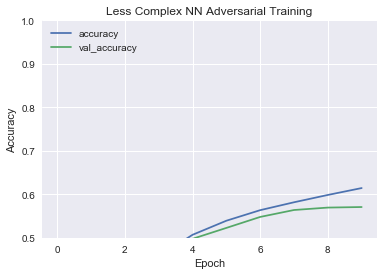

In [110]:
plt.plot(adv_narrow_history.history['accuracy'], label='accuracy')
plt.plot(adv_narrow_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='upper left')
plt.title('Less Complex NN Adversarial Training')
plt.savefig('AdvNarrowTraining.png')

narrow_adv_test_loss, narrow_adv_test_acc = adv_narrow_model.evaluate(narrow_test_images, narrow_test_labels, verbose=2)

375/375 - 6s - loss: 0.9868 - accuracy: 0.7431


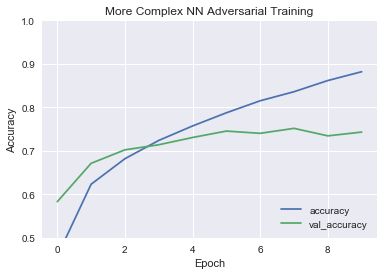

In [111]:
plt.plot(adv_wide_history.history['accuracy'], label='accuracy')
plt.plot(adv_wide_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('More Complex NN Adversarial Training')
plt.savefig('AdvWideTraining.png')


wide_adv_test_loss, wide_adv_test_acc = adv_wide_model.evaluate(wide_test_images, wide_test_labels, verbose=2)